In [1]:
import numpy as np
import cv2
import math
import os
import matplotlib.pyplot as plt

In [3]:
# Camera Calibration
calib_file = 'camera_cal/'
calib_img = os.listdir(calib_file)

nx = 9
ny = 6

image_points = []
object_points = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


for image_name in calib_img:
    
    image = cv2.imread(calib_file + image_name)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        image_points.append(corners)
        object_points.append(objp)

In [4]:
ret, mtx, dist, rvecs, tvects = cv2.calibrateCamera(object_points, image_points, gray.shape, None, None)

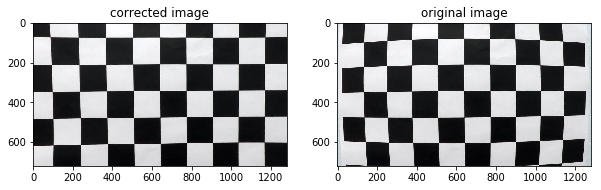

In [5]:
# undistort two example images:
img = cv2.imread(calib_file + calib_img[0])
dst = cv2.undistort(img, mtx, dist,None, mtx)

fig, axs  = plt.subplots(1,2, figsize = (10,4))
axs = axs.ravel()


axs[0].imshow(dst)
axs[0].set_title('corrected image')
axs[1].imshow(img)
axs[1].set_title('original image')

In [6]:
# Select one of the images from the test images folder to start implementing advanced lane finding method
test_images_file = "test_images/"
test_images = os.listdir(test_images_file)

image_name = test_images_file + test_images[0]
image = cv2.imread(image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [7]:
# Undistord the selected test image
undist_image = cv2.undistort(image, mtx, dist, None, mtx)

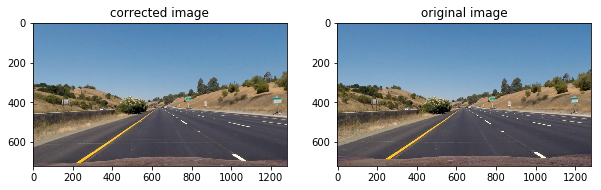

In [8]:
fig, axs  = plt.subplots(1,2, figsize = (10,4))
axs = axs.ravel()


axs[0].imshow(undist_image)
axs[0].set_title('corrected image')
axs[1].imshow(image)
axs[1].set_title('original image')

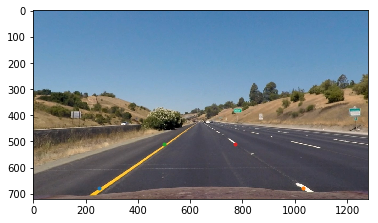

[[  250.   680.]
 [ 1030.   680.]
 [  500.   510.]
 [  770.   510.]]
(720, 1280, 3)


In [33]:
# Use perespective transform to obtain a birds eye view of the road
plt.imshow(undist_image)
plt.plot(250,680,'.')
plt.plot(1030,680,'.')
plt.plot(500,510,'.')
plt.plot(770,510,'.')
plt.show()

src = np.float32([[250, 680],
                 [1030, 680],
                 [500, 510],
                 [770,510]])

print(src)
print(undist_image.shape)

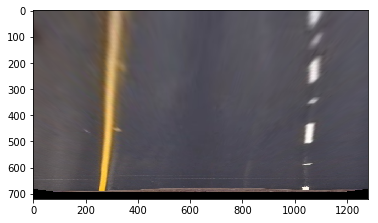

In [35]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32([[250, 680],
                     [1030, 680],
                     [500, 510],
                     [770,510]])
    
    dst = np.float32(
    [[250, 680],
     [1030, 680],
     [250, 510],
     [1030, 510]])
    
    M = cv2.getPerspectiveTransform(src,dst)
    
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    
    return warped

bird_eye = warp(undist_image)

plt.imshow(bird_eye)